## A COVID-19 Analysis

Based on the information at the [Pan-American Health Organization](https://www.paho.org/bra/index.php?option=com_content&view=article&id=6101:covid19&Itemid=875) [1] site:  

    The World Health Organization (WHO) declared, on January 30, 2020, that the outbreak of the disease caused by the new coronavirus (COVID-19) constitutes a Public Health Emergency of International Importance - the Organization's highest alert level, as provided at the International Health Regulations. On March 11, 2020, COVID-19 was characterized by WHO as a pandemic.  

Through the data analysis I'll try to show the main epicenters of virus discemination and the places that are potencially related to that problem, but to be more  concise and practical, the analysis will be centered in the city that I live, São Paulo.  

In that work I'll try to explore some datasets related with the virus and the disease that it causes. The main data, used in the analysis, will be downloaded from the government sites, but some information (related to the districts bondaries) are downloaded from other sources and previous stored on my GitHub account.  

Given the nature of the data, the Visualization and Machine Learning techiniques used to handle that, will be mainly (but not only) focused on the spatial data.  

Because the theme is so delicate, I'm not trying to take any precipitated conclusions nor find any guilted subjects.  

At the end of the work I hope that the audience could take her own decisions with a little more knowledge over the situation.

## Analysis start

First we gona instal all modules and make all needed imports on libraries that we'll use.

In [1]:
#Firstly let's import and install all the libraryes needed

import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from pandas import DataFrame

# this includes some functions to handle datetime data
from datetime import date, datetime, timedelta

#wi use this to spatial data visualisation
!pip install folium
import folium
from folium import LayerControl

#!pip install xlrd
#import xlrd
#import ssl

#used for scraping data
import requests
!pip install bs4
from bs4 import BeautifulSoup

# some functions to clean the data
!pip install unidecode
import unidecode

#this is used to get geospatial data through some service providers
!pip install geopandas
!pip install geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

#We use this for some advanced data manipulation
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.utils

# and that for the machine learning algoritms
from sklearn.cluster import DBSCAN

# Matplotlib and associated plotting modules
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Installations and imports done!')

     |████████████████████████████████| 122kB 5.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 245kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 972kB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 34.1MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 35.8MB/s eta 0:00:01��█████████████████████▊         | 10.4MB 33.2MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 20.3MB/s eta 0:00:01    |███████████████████▍            | 6.6MB 20.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6
     |████████████████████████████████| 112kB 4.4MB/s eta

## Demographic data  

Here we need to scrap the demografic data from the [São Paulo town hall](https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php) [2] site.

In [2]:
url = 'https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php'
html_doc = requests.get(url).text
soup = BeautifulSoup(html_doc, 'html.parser')

In [3]:
table = soup.find('table')
tmp = table.find_all('tr')
first = tmp[0]
allRows = tmp[1:-1]

#for t in range(-4, 0):
#    headers.append(first.find_all('th')[t].get_text())

headers = ['DISTRITO','AREA','POPULACAO','DENSIDADE']

rows = []
for row in allRows:
    cols = []
    for t in range(-4, 0):
        cols.append(row.find_all('td')[t].get_text())
    rows.append(cols)
df_demografia = DataFrame(rows,columns=headers)
df_demografia = df_demografia[df_demografia['DISTRITO'] != 'TOTAL']
print(df_demografia.shape)
df_demografia.head()

(96, 4)


DISTRITO   AREA POPULACAO DENSIDADE
0    Aricanduva   6,60    89.622    13.579
1        Carrão   7,50    83.281    11.104
2  Vila Formosa   7,40    94.799    12.811
4       Butantã  12,50    54.196     4.336
5       Morumbi  11,40    46.957     4.119

In [4]:
#CLEAN THE DATA
s = df_demografia['DISTRITO']
res = s.str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')
df_demografia['DISTRITO'] = res
df_demografia['DISTRITO'] = df_demografia['DISTRITO'].str.upper()
df_demografia['AREA'] = df_demografia['AREA'].str.replace(',','.')
df_demografia['POPULACAO'] = df_demografia['POPULACAO'].str.replace('.','')
df_demografia['POPULACAO'] = df_demografia['POPULACAO'].str.replace(',','')
df_demografia['DENSIDADE'] = df_demografia['DENSIDADE'].str.replace('.','')
df_demografia['DENSIDADE'] = df_demografia['DENSIDADE'].str.replace(',','')

In [5]:
#convert data fields to the corret types
df_demografia['DENSIDADE'] = df_demografia['DENSIDADE'].astype('int64')
df_demografia['POPULACAO'] = df_demografia['POPULACAO'].astype('int64')
df_demografia['AREA'] = df_demografia['AREA'].astype('float')
df_demografia.dtypes

DISTRITO      object
AREA         float64
POPULACAO      int64
DENSIDADE      int64
dtype: object

In [6]:
print(df_demografia.shape)
df_demografia.head()

(96, 4)


DISTRITO  AREA  POPULACAO  DENSIDADE
0    ARICANDUVA   6.6      89622      13579
1        CARRAO   7.5      83281      11104
2  VILA FORMOSA   7.4      94799      12811
4       BUTANTA  12.5      54196       4336
5       MORUMBI  11.4      46957       4119

The data about the boundaries of the territory analysed was previously downloaded from [artefolha.carto.com](https://artefolha.carto.com/tables/distritos_sp/public/map) [3] site and uploaded at my GitHub account.

In [7]:
#geo spatial data of the analysed area
cid_sp_geo = 'https://raw.githubusercontent.com/UgoCesar19/Coursera_Capstone/master/distritos_sp.geojson'

To know if the spatial data will be sussefull merged with the demografic data, we gona create a dataframe withe the feature atributes inside the geojson file. 

In [8]:
# make a data frame with the geojson feature atributes
df_distritos = []
json_sp = requests.get(cid_sp_geo).json()
for feature in json_sp['features']:
    df_distritos.append(feature['properties'])

df_distritos = DataFrame(df_distritos)
print(df_distritos.shape)
df_distritos.head()

(96, 9)


cartodb_id   id mun_sigla   mun_nome   cod_ibge sigla          nome  \
0          34   22       SAO  SAO PAULO  355030807   BVI    Bela Vista   
1          38   24       SAO  SAO PAULO  355030849   LIB     Liberdade   
2          42  259       SAO  SAO PAULO  355030856   PRI          Pari   
3          21   30       SAO  SAO PAULO  355030853   MOO         Mooca   
4           8    3       SAO  SAO PAULO  355030883   VAN  Vila Andrade   

       nomecaps  incidencia  
0    BELA VISTA         8.5  
1     LIBERDADE         7.1  
2          PARI        16.4  
3         MOOCA         5.1  
4  VILA ANDRADE         2.2

Then we merge the data and look for some discrepanci.

In [9]:
# make an join to compare the data in the dataframes
df_dist_pop = df_distritos.merge(df_demografia, left_on='nomecaps', right_on='DISTRITO', how='outer')
print(df_dist_pop.shape)
df_dist_pop.head()

(96, 13)


cartodb_id   id mun_sigla   mun_nome   cod_ibge sigla          nome  \
0          34   22       SAO  SAO PAULO  355030807   BVI    Bela Vista   
1          38   24       SAO  SAO PAULO  355030849   LIB     Liberdade   
2          42  259       SAO  SAO PAULO  355030856   PRI          Pari   
3          21   30       SAO  SAO PAULO  355030853   MOO         Mooca   
4           8    3       SAO  SAO PAULO  355030883   VAN  Vila Andrade   

       nomecaps  incidencia      DISTRITO  AREA  POPULACAO  DENSIDADE  
0    BELA VISTA         8.5    BELA VISTA   2.6      69460      26715  
1     LIBERDADE         7.1     LIBERDADE   3.7      69092      18674  
2          PARI        16.4          PARI   2.9      17299       5965  
3         MOOCA         5.1         MOOCA   7.7      75724       9834  
4  VILA ANDRADE         2.2  VILA ANDRADE  10.3     127015      12332

In [10]:
#searsh for empty fields
print('Testa chave DISTRITO')
print(df_dist_pop['DISTRITO'].isna().value_counts())

print('\nTesta chave nomecaps')
print(df_dist_pop['nomecaps'].isna().value_counts())

print(df_dist_pop[df_dist_pop['DISTRITO'].isna()]['nomecaps'])
print(df_dist_pop[df_dist_pop['nomecaps'].isna()]['DISTRITO'])

Testa chave DISTRITO
False    96
Name: DISTRITO, dtype: int64

Testa chave nomecaps
False    96
Name: nomecaps, dtype: int64
Series([], Name: nomecaps, dtype: object)
Series([], Name: DISTRITO, dtype: object)


Every district in the geojson file corresponds with one district in our demografic dataset. So the data merge perfectly.  
With the data validated, we could plot that using folium cloropleth map.  

## To se what areas have the greater populational density.

In [11]:
#with the data validated, present it with folium cloropleth map
sao_paulo_map = folium.Map(location=[-23.68,-46.6], zoom_start=10)

sao_paulo_map.choropleth(
    geo_data=cid_sp_geo,
    name='Densidade populacional',
    data=df_demografia,
    columns=['DISTRITO','DENSIDADE'],
    key_on='feature.properties.nomecaps',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densidade populacional'
)

sao_paulo_map

The stronger the color, the greater the density.  

## COVID-19 data

Taking this into account, let's download the data about covid and start analysing it.  
We gona get this data from [openDataSUS](https://opendatasus.saude.gov.br/dataset/casos-nacionais) [4], an government site that centralizes that data.

In [12]:
# we know which districts are the most populous
# now let's read the data about covid
df_covid = pd.read_csv('https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/dados-sp.csv', encoding = "ISO-8859-1", delimiter=';', error_bad_lines=False)
print('Covid data imported!')

b'Skipping line 46285: expected 33 fields, saw 34\n'
b'Skipping line 56648: expected 33 fields, saw 34\nSkipping line 58860: expected 33 fields, saw 34\n'
b'Skipping line 83455: expected 33 fields, saw 34\n'
b'Skipping line 302898: expected 33 fields, saw 34\n'
b'Skipping line 391719: expected 33 fields, saw 34\n'
b'Skipping line 407255: expected 33 fields, saw 34\nSkipping line 407278: expected 33 fields, saw 34\n'
b'Skipping line 431604: expected 33 fields, saw 36\n'
b'Skipping line 489400: expected 33 fields, saw 34\nSkipping line 489462: expected 33 fields, saw 34\n'
b'Skipping line 557884: expected 33 fields, saw 34\n'
b'Skipping line 594412: expected 33 fields, saw 34\n'
b'Skipping line 727925: expected 33 fields, saw 34\n'
b'Skipping line 826209: expected 33 fields, saw 34\n'
b'Skipping line 840011: expected 33 fields, saw 34\nSkipping line 848880: expected 33 fields, saw 34\n'
b'Skipping line 870207: expected 33 fields, saw 34\n'
b'Skipping line 1038835: expected 33 fields, saw

Covid data imported!


In [13]:
#than take a look at the data
print(df_covid.shape)
df_covid.head()

(1881960, 33)


ÿid           dataNotificacao        dataInicioSintomas  \
0  RuiOG4SBzv  2020-03-28T02:44:37.023Z  2020-03-23T03:00:00.000Z   
1  YdhVyyPS1E  2020-03-28T02:47:38.794Z  2020-03-23T03:00:00.000Z   
2  XIgukQcc74  2020-03-28T02:51:34.881Z  2020-03-22T03:00:00.000Z   
3  wOCAnpg72C  2020-03-28T02:51:07.609Z  2020-03-27T03:00:00.000Z   
4  XQrrXRxX2B  2020-03-28T02:56:34.589Z  2020-03-15T03:00:00.000Z   

             dataNascimento               sintomas profissionalSaude  \
0  1986-02-27T02:00:00.000Z  Dor de Garganta,Febre               Sim   
1  1984-10-16T03:00:00.000Z                  Tosse               Sim   
2  1980-08-31T03:00:00.000Z                  Febre               Sim   
3  1969-12-19T03:00:00.000Z         Tosse,Dispneia               Sim   
4  1976-06-04T03:00:00.000Z                  Tosse               Não   

                                                 cbo condicoes estadoTeste  \
0                                  2235 - ENFERMEIRO       NaN   Concluído   
1  3242 - TÉCNICO DE LABORATÓRIO DE SAÚDE OU BANC...       NaN   Concluído   
2           3222 - TÉCNICO OU AUXILIAR EM ENFERMAGEM       NaN   Concluído   
3                                  2235 - ENFERMEIRO       NaN    Coletado   
4                                                NaN       NaN   Concluído   

                  dataTeste  ... estadoNotificacaoIBGE   municipioNotificacao  \
0  2020-03-25T03:00:00.000Z  ...                    35              São Paulo   
1  2020-03-15T03:00:00.000Z  ...                    35              São Paulo   
2  2020-03-25T03:00:00.000Z  ...                    35              São Paulo   
3  2020-03-27T03:00:00.000Z  ...                    35  São Bernardo do Campo   
4  2020-03-15T03:00:00.000Z  ...                    35              São Paulo   

  municipioNotificacaoIBGE numeroNotificacao   excluido   validado idade  \
0                  3550308      352000013349  undefined  undefined    34   
1                  3550308      352000013352  undefined  undefined    35   
2                  3550308      352000013360  undefined  undefined    39   
3                  3548708      352000013361  undefined  undefined    50   
4                  3550308      352000013362  undefined  undefined    44   

  dataEncerramento evolucaoCaso classificacaoFinal  
0              NaN          NaN                NaN  
1              NaN          NaN                NaN  
2              NaN          NaN                NaN  
3              NaN          NaN                NaN  
4              NaN          NaN                NaN  

[5 rows x 33 columns]

This dataset contains information about the cases of Flu Syndrome. Part of that data is labeled as COVID-19 confirmed cases.  
Other thing is that our dataframe contains data from other citys, out of this work scope.  
We have to filter the data.

In [14]:
# the dataset brings data from the entire state, so let's get just what we want for the analises
df_covid = df_covid[df_covid['resultadoTeste'] == 'Positivo']
df_covid = df_covid[df_covid['municipio'] == 'São Paulo']
print(df_covid.shape)
df_covid.head()

(169275, 33)


ÿid           dataNotificacao        dataInicioSintomas  \
0  RuiOG4SBzv  2020-03-28T02:44:37.023Z  2020-03-23T03:00:00.000Z   
1  YdhVyyPS1E  2020-03-28T02:47:38.794Z  2020-03-23T03:00:00.000Z   
4  XQrrXRxX2B  2020-03-28T02:56:34.589Z  2020-03-15T03:00:00.000Z   
6  nCiyaLSHvm  2020-03-28T03:04:13.937Z  2020-03-23T03:00:00.000Z   
7  9xnSLCrp3P  2020-03-28T03:13:21.021Z  2020-03-20T03:00:00.000Z   

             dataNascimento               sintomas profissionalSaude  \
0  1986-02-27T02:00:00.000Z  Dor de Garganta,Febre               Sim   
1  1984-10-16T03:00:00.000Z                  Tosse               Sim   
4  1976-06-04T03:00:00.000Z                  Tosse               Não   
6  1980-12-29T03:00:00.000Z                  Febre               Sim   
7  1988-07-07T03:00:00.000Z            Tosse,Febre               Sim   

                                                 cbo condicoes estadoTeste  \
0                                  2235 - ENFERMEIRO       NaN   Concluído   
1  3242 - TÉCNICO DE LABORATÓRIO DE SAÚDE OU BANC...       NaN   Concluído   
4                                                NaN       NaN   Concluído   
6                     5153 - AUXILIAR DA ÁREA SOCIAL       NaN   Concluído   
7                                  2235 - ENFERMEIRO       NaN   Concluído   

                  dataTeste  ... estadoNotificacaoIBGE municipioNotificacao  \
0  2020-03-25T03:00:00.000Z  ...                    35            São Paulo   
1  2020-03-15T03:00:00.000Z  ...                    35            São Paulo   
4  2020-03-15T03:00:00.000Z  ...                    35            São Paulo   
6  2020-03-25T03:00:00.000Z  ...                    35            São Paulo   
7  2020-03-25T03:00:00.000Z  ...                    35            São Paulo   

  municipioNotificacaoIBGE numeroNotificacao   excluido   validado idade  \
0                  3550308      352000013349  undefined  undefined    34   
1                  3550308      352000013352  undefined  undefined    35   
4                  3550308      352000013362  undefined  undefined    44   
6                  3550308      352000013384  undefined  undefined    39   
7                  3550308      352000013392  undefined  undefined    32   

  dataEncerramento evolucaoCaso classificacaoFinal  
0              NaN          NaN                NaN  
1              NaN          NaN                NaN  
4              NaN          NaN                NaN  
6              NaN          NaN                NaN  
7              NaN          NaN                NaN  

[5 rows x 33 columns]

Here we gona convert the data type of the field related to the notification date to the correspondent data type.

In [15]:
#convert notification date to the correct data type
df_covid['dataNotificacao'] = df_covid['dataNotificacao'].astype('datetime64')
print(df_covid.dtypes)

ÿid                                 object
dataNotificacao             datetime64[ns]
dataInicioSintomas                  object
dataNascimento                      object
sintomas                            object
profissionalSaude                   object
cbo                                 object
condicoes                           object
estadoTeste                         object
dataTeste                           object
tipoTeste                           object
resultadoTeste                      object
paisOrigem                          object
sexo                                object
bairro                              object
estado                              object
estadoIBGE                          object
municipio                           object
municipioIBGE                       object
cep                                 object
origem                              object
cnes                                object
estadoNotificacao                   object
estadoNotif

Now we create a field representing the week of notification.

In [16]:
#get first date of each week
#pd.to_datetime(df_covid['dataNotificacao'], format='%Y-%m-%d')
df_covid['semanaNotificacao'] = df_covid['dataNotificacao'].dt.date - df_covid['dataNotificacao'].dt.weekday * timedelta(days=1)
print(df_covid.shape)
df_covid.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized
  PerformanceWarning,


(169275, 34)


ÿid         dataNotificacao        dataInicioSintomas  \
0  RuiOG4SBzv 2020-03-28 02:44:37.023  2020-03-23T03:00:00.000Z   
1  YdhVyyPS1E 2020-03-28 02:47:38.794  2020-03-23T03:00:00.000Z   
4  XQrrXRxX2B 2020-03-28 02:56:34.589  2020-03-15T03:00:00.000Z   
6  nCiyaLSHvm 2020-03-28 03:04:13.937  2020-03-23T03:00:00.000Z   
7  9xnSLCrp3P 2020-03-28 03:13:21.021  2020-03-20T03:00:00.000Z   

             dataNascimento               sintomas profissionalSaude  \
0  1986-02-27T02:00:00.000Z  Dor de Garganta,Febre               Sim   
1  1984-10-16T03:00:00.000Z                  Tosse               Sim   
4  1976-06-04T03:00:00.000Z                  Tosse               Não   
6  1980-12-29T03:00:00.000Z                  Febre               Sim   
7  1988-07-07T03:00:00.000Z            Tosse,Febre               Sim   

                                                 cbo condicoes estadoTeste  \
0                                  2235 - ENFERMEIRO       NaN   Concluído   
1  3242 - TÉCNICO DE LABORATÓRIO DE SAÚDE OU BANC...       NaN   Concluído   
4                                                NaN       NaN   Concluído   
6                     5153 - AUXILIAR DA ÁREA SOCIAL       NaN   Concluído   
7                                  2235 - ENFERMEIRO       NaN   Concluído   

                  dataTeste  ... municipioNotificacao  \
0  2020-03-25T03:00:00.000Z  ...            São Paulo   
1  2020-03-15T03:00:00.000Z  ...            São Paulo   
4  2020-03-15T03:00:00.000Z  ...            São Paulo   
6  2020-03-25T03:00:00.000Z  ...            São Paulo   
7  2020-03-25T03:00:00.000Z  ...            São Paulo   

  municipioNotificacaoIBGE numeroNotificacao   excluido   validado idade  \
0                  3550308      352000013349  undefined  undefined    34   
1                  3550308      352000013352  undefined  undefined    35   
4                  3550308      352000013362  undefined  undefined    44   
6                  3550308      352000013384  undefined  undefined    39   
7                  3550308      352000013392  undefined  undefined    32   

  dataEncerramento evolucaoCaso classificacaoFinal semanaNotificacao  
0              NaN          NaN                NaN        2020-03-23  
1              NaN          NaN                NaN        2020-03-23  
4              NaN          NaN                NaN        2020-03-23  
6              NaN          NaN                NaN        2020-03-23  
7              NaN          NaN                NaN        2020-03-23  

[5 rows x 34 columns]

And count the number of cases per week.

In [17]:
#get number of cases per week
covid_per_week = df_covid['semanaNotificacao'].value_counts()
covid_per_week = covid_per_week.to_frame()
covid_per_week.reset_index(inplace=True)
covid_per_week.rename(columns={'semanaNotificacao':'total', 'index':'semanaNotificacao'}, inplace=True)
covid_per_week.sort_values(by='semanaNotificacao', ascending=True, inplace=True)
covid_per_week.index = covid_per_week.semanaNotificacao
covid_per_week.drop('semanaNotificacao', axis=1, inplace=True)
covid_per_week

total
semanaNotificacao       
2020-02-24             5
2020-03-02            22
2020-03-09           333
2020-03-16           730
2020-03-23           985
2020-03-30          2013
2020-04-06          2725
2020-04-13          3678
2020-04-20          4095
2020-04-27          6284
2020-05-04          6954
2020-05-11          8320
2020-05-18         11180
2020-05-25         15039
2020-06-01         15006
2020-06-08         17175
2020-06-15         25427
2020-06-22         16637
2020-06-29         13311
2020-07-06         12386
2020-07-13          6955
2020-08-03             1

## Basic historical panorama

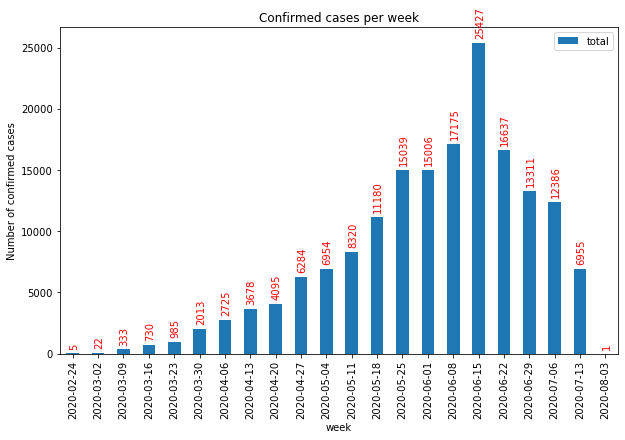

In [18]:
covid_per_week.plot(kind='bar', figsize=(10, 6))

plt.xlabel('week') # add to x-label to the plot
plt.ylabel('Number of confirmed cases') # add y-label to the plot
plt.title('Confirmed cases per week') # add title to the plot

# annotate value labels to each week
for index, value in enumerate(covid_per_week.values):
    #print(index, value) 
        
    # place text at the end of bar
    plt.annotate(value[0], xy=(index - 0.15, value + 500), rotation=90, color='red')

plt.show()

Here we could spot the weeks with mos cases reported to conclude if we're in a up or down curve. 

In [19]:
#let's get a sub set of the data representing confirmed cases in the last 14 days
casos_ativos = df_covid[df_covid['dataNotificacao'].dt.date > date.today() - timedelta(14)]
casos_ativos['dataNotificacao'] = casos_ativos['dataNotificacao'].dt.date
print(casos_ativos.shape)
casos_ativos.head()

(19342, 34)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ÿid dataNotificacao        dataInicioSintomas  \
919611  nfZMKsabzP      2020-07-06  2020-07-02T03:00:00.000Z   
919650  Er1cGaOFUD      2020-07-06  2020-05-10T03:00:00.000Z   
919671  kXsKrgQtjW      2020-07-06  2020-06-29T03:00:00.000Z   
919699  1Yl6CKplle      2020-07-06  2020-06-19T03:00:00.000Z   
919717  idsmc9lRsj      2020-07-06  2020-06-19T03:00:00.000Z   

                  dataNascimento       sintomas profissionalSaude  cbo  \
919611  1983-05-16T03:00:00.000Z         Outros               Não  NaN   
919650  1969-03-26T03:00:00.000Z  Tosse, Outros               Não  NaN   
919671  1995-03-17T03:00:00.000Z         Outros               Não  NaN   
919699  1988-11-13T02:00:00.000Z         Outros               Não  NaN   
919717  1975-06-23T03:00:00.000Z         Outros               Não  NaN   

       condicoes estadoTeste                 dataTeste  ...  \
919611       NaN   Concluído  2020-07-02T03:00:00.000Z  ...   
919650       NaN   Concluído  2020-05-10T03:00:00.000Z  ...   
919671       NaN   Concluído  2020-07-03T03:00:00.000Z  ...   
919699       NaN   Concluído  2020-06-22T03:00:00.000Z  ...   
919717       NaN   Concluído  2020-07-06T03:00:00.000Z  ...   

       municipioNotificacao municipioNotificacaoIBGE numeroNotificacao  \
919611            São Paulo                  3550308      352008376190   
919650            São Paulo                  3550308      352008376375   
919671            São Paulo                  3550308      352008376409   
919699            São Paulo                  3550308      352008376610   
919717            São Paulo                  3550308      352008376634   

         excluido   validado idade dataEncerramento evolucaoCaso  \
919611  undefined  undefined    37              NaN          NaN   
919650  undefined  undefined    51              NaN          NaN   
919671  undefined  undefined    25              NaN          NaN   
919699  undefined  undefined    31              NaN          NaN   
919717  undefined  undefined    45              NaN          NaN   

       classificacaoFinal semanaNotificacao  
919611                NaN        2020-07-06  
919650                NaN        2020-07-06  
919671                NaN        2020-07-06  
919699                NaN        2020-07-06  
919717                NaN        2020-07-06  

[5 rows x 34 columns]

Then we gona see the number of cases per day in that "active COVID" dataset.

In [20]:
#get number of cases per day
covid_per_day = casos_ativos['dataNotificacao'].value_counts()
covid_per_day = covid_per_day.to_frame()
covid_per_day.reset_index(inplace=True)
covid_per_day.rename(columns={'dataNotificacao':'total', 'index':'dataNotificacao'}, inplace=True)
covid_per_day.sort_values(by='dataNotificacao', ascending=True, inplace=True)
covid_per_day.index = covid_per_day.dataNotificacao
covid_per_day.drop('dataNotificacao', axis=1, inplace=True)
covid_per_day

total
dataNotificacao       
2020-07-06        2894
2020-07-07        2260
2020-07-08        2364
2020-07-09        1882
2020-07-10        1900
2020-07-11         811
2020-07-12         275
2020-07-13        1713
2020-07-14        1184
2020-07-15        1069
2020-07-16         747
2020-07-17        1612
2020-07-18         624
2020-07-19           6
2020-08-07           1

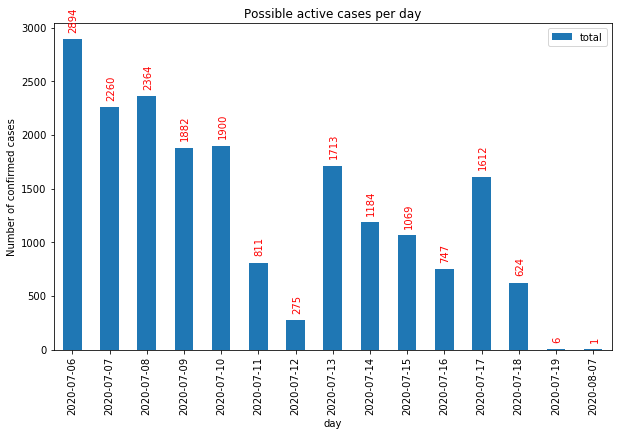

In [21]:
covid_per_day.plot(kind='bar', figsize=(10, 6))

plt.xlabel('day') # add to x-label to the plot
plt.ylabel('Number of confirmed cases') # add y-label to the plot
plt.title('Possible active cases per day') # add title to the plot

# annotate value labels to each week
for index, value in enumerate(covid_per_day.values):
    # place text at the end of bar
    plt.annotate(value[0], xy=(index - 0.1, value + 80), rotation=90, color='red')

plt.show()

We're foccusing on the most recent cases becouse they could potencially be still active.  

With a first panorama of COVID-19 at São Paulo - SP, we could focus on the most recent cases reported and proceed with the spatial analyses.

## So let's spot the possible active cases and analise the geospatial data

At that point we'll try to group cases by neighborhood.  
But first we have to clean the data trying to combine diferent typing ways of the same places into single groups.

In [22]:
#remove special characters and accents from neighborhood name
s = casos_ativos['bairro']
res = s.str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')
casos_ativos['bairro'] = res

#convert neighborhood names to upper case
casos_ativos['bairro'] = casos_ativos['bairro'].str.upper()
casos_ativos['bairro']

#remove extra spaces from the neighborhood names
casos_ativos['bairro'] = casos_ativos['bairro'].str.lstrip()
casos_ativos['bairro'] = casos_ativos['bairro'].str.rstrip()

print(casos_ativos.shape)
casos_ativos.head()

(19342, 34)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

ÿid dataNotificacao        dataInicioSintomas  \
919611  nfZMKsabzP      2020-07-06  2020-07-02T03:00:00.000Z   
919650  Er1cGaOFUD      2020-07-06  2020-05-10T03:00:00.000Z   
919671  kXsKrgQtjW      2020-07-06  2020-06-29T03:00:00.000Z   
919699  1Yl6CKplle      2020-07-06  2020-06-19T03:00:00.000Z   
919717  idsmc9lRsj      2020-07-06  2020-06-19T03:00:00.000Z   

                  dataNascimento       sintomas profissionalSaude  cbo  \
919611  1983-05-16T03:00:00.000Z         Outros               Não  NaN   
919650  1969-03-26T03:00:00.000Z  Tosse, Outros               Não  NaN   
919671  1995-03-17T03:00:00.000Z         Outros               Não  NaN   
919699  1988-11-13T02:00:00.000Z         Outros               Não  NaN   
919717  1975-06-23T03:00:00.000Z         Outros               Não  NaN   

       condicoes estadoTeste                 dataTeste  ...  \
919611       NaN   Concluído  2020-07-02T03:00:00.000Z  ...   
919650       NaN   Concluído  2020-05-10T03:00:00.000Z  ...   
919671       NaN   Concluído  2020-07-03T03:00:00.000Z  ...   
919699       NaN   Concluído  2020-06-22T03:00:00.000Z  ...   
919717       NaN   Concluído  2020-07-06T03:00:00.000Z  ...   

       municipioNotificacao municipioNotificacaoIBGE numeroNotificacao  \
919611            São Paulo                  3550308      352008376190   
919650            São Paulo                  3550308      352008376375   
919671            São Paulo                  3550308      352008376409   
919699            São Paulo                  3550308      352008376610   
919717            São Paulo                  3550308      352008376634   

         excluido   validado idade dataEncerramento evolucaoCaso  \
919611  undefined  undefined    37              NaN          NaN   
919650  undefined  undefined    51              NaN          NaN   
919671  undefined  undefined    25              NaN          NaN   
919699  undefined  undefined    31              NaN          NaN   
919717  undefined  undefined    45              NaN          NaN   

       classificacaoFinal semanaNotificacao  
919611                NaN        2020-07-06  
919650                NaN        2020-07-06  
919671                NaN        2020-07-06  
919699                NaN        2020-07-06  
919717                NaN        2020-07-06  

[5 rows x 34 columns]

With the data about neighborhoods cleaned, we could group the cases.

In [23]:
#group covid cases by neighborhood
covid_bairros = casos_ativos['bairro'].value_counts()
covid_bairros = covid_bairros.to_frame()
covid_bairros.reset_index(inplace=True)
covid_bairros.rename(columns={'bairro':'total', 'index':'bairro'}, inplace=True)
covid_bairros['bairro'] = covid_bairros['bairro'] + ', São Paulo - SP'
print(covid_bairros.shape)
covid_bairros.head()

(4168, 2)


bairro  total
0  UNIAO DE VILA NOVA, São Paulo - SP    371
1          BELA VISTA, São Paulo - SP    242
2            ITAQUERA, São Paulo - SP    216
3      SEM INFORMACAO, São Paulo - SP    185
4            BARRAGEM, São Paulo - SP    168

Then we could search for de geospatial data using geopy library and nominatim services, to be able to represent this data in our map.  

## Find geospatial data about neighborhoods

In [24]:
#find the geospatial data for each neighborhood
locator = Nominatim(user_agent='Analise-COVID19')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=0.1)
# 2- - create location column
covid_bairros['location'] = covid_bairros['bairro'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
covid_bairros['point'] = covid_bairros['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns

RateLimiter caught an error, retrying (0/2 tries). Called with (*('J BRASIL, São Paulo - SP',), **{}).
Traceback (most recent call last):
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 1354, in getresponse
    response.begin()
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/home/jupyterlab/conda/envs/python/lib/python3.6/socket.py", line 

Then we extract the geografical coordinates from the data to separete data fields.

In [25]:
points = []
for i in covid_bairros['point'].to_list():
    if i is None:
        points.append((None,None,None))
    else:
        points.append(i)

covid_bairros[['latitude', 'longitude', 'altitude']] = pd.DataFrame(points, columns =['latitude', 'longitude', 'altitude'])
print(covid_bairros.shape)
covid_bairros.head()

(4168, 7)


bairro  total  \
0  UNIAO DE VILA NOVA, São Paulo - SP    371   
1          BELA VISTA, São Paulo - SP    242   
2            ITAQUERA, São Paulo - SP    216   
3      SEM INFORMACAO, São Paulo - SP    185   
4            BARRAGEM, São Paulo - SP    168   

                                            location  \
0                                               None   
1  (Bela Vista, São Paulo, Região Sudeste, Brasil...   
2  (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
3  (Informação, Avenida 22 de Março, Canas, Regiã...   
4  (Barragem, Queluz, Região Imediata de Cruzeiro...   

                                    point   latitude  longitude  altitude  
0                                    None        NaN        NaN       NaN  
1  (-23.5622095, -46.64776648788944, 0.0) -23.562210 -46.647766       0.0  
2         (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510       0.0  
3          (-22.7050811, -45.054741, 0.0) -22.705081 -45.054741       0.0  
4         (-22.5432596, -44.7959838, 0.0) -22.543260 -44.795984       0.0

## Analysing the data

In [51]:
#searsh for empty fields
print('\nTesta latitude')
print(covid_bairros['latitude'].isna().value_counts())

print('\nTesta longitude')
print(covid_bairros['longitude'].isna().value_counts())

covid_bairros['found'] = ~covid_bairros['longitude'].isna()

covid_bairros[['found','total']].groupby('found').sum().sort_values(by='total', ascending=False).reset_index()


Testa latitude
True     2412
False    1756
Name: latitude, dtype: int64

Testa longitude
True     2412
False    1756
Name: longitude, dtype: int64


found  total
0   True  12992
1  False   6051

Here we could see that the the geospatial information about the neighborhoods reporting COVID-19 cases for a lot of places was not found by the geolocation service we used.  

The information returned by the service points, between other things, to places that doesn't even exists.  
It suggests that this information is manually inputted.

But we still have information of many places with confirmed COVID-19 cases, so let's examine this places.

In [52]:
#make a dataframe with only data with geospatial information
df_covid_geo = covid_bairros[covid_bairros['found']]
df_covid_geo.drop(['altitude'], axis=1, inplace=True)
print(df_covid_geo.shape)
df_covid_geo.head()

(1756, 7)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


bairro  total  \
1      BELA VISTA, São Paulo - SP    242   
2        ITAQUERA, São Paulo - SP    216   
3  SEM INFORMACAO, São Paulo - SP    185   
4        BARRAGEM, São Paulo - SP    168   
5         TATUAPE, São Paulo - SP    166   

                                            location  \
1  (Bela Vista, São Paulo, Região Sudeste, Brasil...   
2  (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
3  (Informação, Avenida 22 de Março, Canas, Regiã...   
4  (Barragem, Queluz, Região Imediata de Cruzeiro...   
5  (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   

                                    point   latitude  longitude  found  
1  (-23.5622095, -46.64776648788944, 0.0) -23.562210 -46.647766   True  
2         (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True  
3          (-22.7050811, -45.054741, 0.0) -22.705081 -45.054741   True  
4         (-22.5432596, -44.7959838, 0.0) -22.543260 -44.795984   True  
5         (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True

Here we define a number to represent the proportion in number of cases by neighborhood compared to the total number of cases.

In [53]:
scaler = preprocessing.MinMaxScaler()
df_covid_geo['proporcao'] = scaler.fit_transform(df_covid_geo[['total']])
df_covid_geo.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


bairro  total  \
1      BELA VISTA, São Paulo - SP    242   
2        ITAQUERA, São Paulo - SP    216   
3  SEM INFORMACAO, São Paulo - SP    185   
4        BARRAGEM, São Paulo - SP    168   
5         TATUAPE, São Paulo - SP    166   

                                            location  \
1  (Bela Vista, São Paulo, Região Sudeste, Brasil...   
2  (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
3  (Informação, Avenida 22 de Março, Canas, Regiã...   
4  (Barragem, Queluz, Região Imediata de Cruzeiro...   
5  (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   

                                    point   latitude  longitude  found  \
1  (-23.5622095, -46.64776648788944, 0.0) -23.562210 -46.647766   True   
2         (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   
3          (-22.7050811, -45.054741, 0.0) -22.705081 -45.054741   True   
4         (-22.5432596, -44.7959838, 0.0) -22.543260 -44.795984   True   
5         (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   

   proporcao  
1   1.000000  
2   0.892116  
3   0.763485  
4   0.692946  
5   0.684647

With all that information we could, for the first time, plot the data in a map to a better visualysation.

In [54]:
sao_paulo_map = folium.Map(location=[-23.68,-46.6], zoom_start=7)

sao_paulo_map.choropleth(
    geo_data=cid_sp_geo,
    name='Densidade populacional',
    data=df_demografia,
    columns=['DISTRITO','DENSIDADE'],
    key_on='feature.properties.nomecaps',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densidade populacional'
)

# instantiate a feature group for the covid cases in the dataframe
covid_cases = folium.map.FeatureGroup(name='Covid cases')

# loop through each neighborhood
for lat, lng, prop in zip(df_covid_geo.latitude, df_covid_geo.longitude, df_covid_geo.proporcao):
    covid_cases.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10*prop, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='white',
            fill_opacity=0.6
        )
    )

# add covid cases to map
sao_paulo_map.add_child(covid_cases)

At this point we could conclude a couple of things:
1. Our data have outliers (a lot of cases are from out of the city);  
2. By zooming in we see that our cases are concentrated in the most populous districts.

## Clustering

Trying to better our understand, lets get rid of the outliers and find the main epicenters of the virus.  
For that we'll use an machine learning algoritm named DBSCAN (Densit-Based Spatial Clustering of Applications with Noise).

In [55]:
#slyce the geospatial data from our dataset and preprocess it.
Clus_dataSet = df_covid_geo[['latitude','longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.03, min_samples=12).fit(Clus_dataSet)

# Label our dataset with the clusters formed
labels = db.labels_
df_covid_geo["epicenter"]=labels

# create variables to facilitate future operations with the clusters 
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# view the data
print(set(labels))
df_covid_geo.head()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


bairro  total  \
1      BELA VISTA, São Paulo - SP    242   
2        ITAQUERA, São Paulo - SP    216   
3  SEM INFORMACAO, São Paulo - SP    185   
4        BARRAGEM, São Paulo - SP    168   
5         TATUAPE, São Paulo - SP    166   

                                            location  \
1  (Bela Vista, São Paulo, Região Sudeste, Brasil...   
2  (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
3  (Informação, Avenida 22 de Março, Canas, Regiã...   
4  (Barragem, Queluz, Região Imediata de Cruzeiro...   
5  (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   

                                    point   latitude  longitude  found  \
1  (-23.5622095, -46.64776648788944, 0.0) -23.562210 -46.647766   True   
2         (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   
3          (-22.7050811, -45.054741, 0.0) -22.705081 -45.054741   True   
4         (-22.5432596, -44.7959838, 0.0) -22.543260 -44.795984   True   
5         (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   

   proporcao  epicenter  
1   1.000000          0  
2   0.892116          0  
3   0.763485         -1  
4   0.692946         -1  
5   0.684647          0

With our data labeled we could better see only the data that our work is foccused. 

In [56]:
sao_paulo_map = folium.Map(location=[-23.68,-46.6], zoom_start=7)

sao_paulo_map.choropleth(
    geo_data=cid_sp_geo,
    name='Densidade populacional',
    data=df_demografia,
    columns=['DISTRITO','DENSIDADE'],
    key_on='feature.properties.nomecaps',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densidade populacional'
)

# instantiate a feature group for the covid cases in the dataframe
covid_epicenters = folium.map.FeatureGroup(name='Epicenters')

#make some colors for each cluster
cores = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

# loop through each neighborhood
for lat, lng, prop, epi in zip(df_covid_geo.latitude, df_covid_geo.longitude, df_covid_geo.proporcao, df_covid_geo.epicenter):
    c=(([0.4,0.4,0.4]) if epi == -1 else cores[np.int(epi)])
    hexcolor = colors.rgb2hex(c)
    covid_epicenters.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10*prop, # define how big you want the circle markers to be
            color=hexcolor,
            fill=True,
            fill_color=hexcolor,
            fill_opacity=0.6
        )
    )

# add covid cases to map
sao_paulo_map.add_child(covid_epicenters)

# instantiate a feature group for the labels generated
epicenter_labels = folium.map.FeatureGroup(name='Epicenter labels')

for cluster in range(realClusterNum):
    lat=np.mean(df_covid_geo[df_covid_geo['epicenter'] == cluster].latitude) 
    lon=np.mean(df_covid_geo[df_covid_geo['epicenter'] == cluster].longitude)
    
    folium.Marker([lat, lon], popup='Epicenter No ' + str(cluster)).add_to(epicenter_labels)

#add the markers to the map
sao_paulo_map.add_child(epicenter_labels)

folium.LayerControl().add_to(sao_paulo_map)

sao_paulo_map

Here we could see a big cluster centered at the city we are analysing.  
Let's use the respective label to generate a filtered dataset.

In [57]:
# group confirmed cases by label
cases_by_epicenter = df_covid_geo[['epicenter','total']].groupby('epicenter').sum().sort_values(by='total', ascending=False).reset_index()
cases_by_epicenter.head()

epicenter  total
0          0   9217
1         -1   2636
2          1    295
3          2    178
4          3    130

In [58]:
main_epicenter = cases_by_epicenter.iloc[0][0]
main_epicenter

0

In [59]:
df_filtered = df_covid_geo[df_covid_geo['epicenter'] == main_epicenter]
print(df_filtered.shape)
df_filtered.head()

(994, 9)


bairro  total  \
1       BELA VISTA, São Paulo - SP    242   
2         ITAQUERA, São Paulo - SP    216   
5          TATUAPE, São Paulo - SP    166   
6  VILA LEOPOLDINA, São Paulo - SP    151   
7   ITAIM PAULISTA, São Paulo - SP    131   

                                            location  \
1  (Bela Vista, São Paulo, Região Sudeste, Brasil...   
2  (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
5  (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   
6  (Vila Leopoldina, São Paulo, Região Sudeste, B...   
7  (Itaim Paulista, São Paulo, Região Sudeste, Br...   

                                    point   latitude  longitude  found  \
1  (-23.5622095, -46.64776648788944, 0.0) -23.562210 -46.647766   True   
2         (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   
5         (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   
6   (-23.530072, -46.73431933313398, 0.0) -23.530072 -46.734319   True   
7         (-23.5017648, -46.3996091, 0.0) -23.501765 -46.399609   True   

   proporcao  epicenter  
1   1.000000          0  
2   0.892116          0  
5   0.684647          0  
6   0.622407          0  
7   0.539419          0

Now we will use the same machine learning algoritm, to generate clusters in the filtered data

In [60]:
#slyce the geospatial data from our dataset and preprocess it.
Clus_dataSet = df_filtered[['latitude','longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=13).fit(Clus_dataSet)

# label our data
labels = db.labels_
df_filtered["epicenter"]=labels

# create variables for a better data handling
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

print(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Then we'll plot the data again zooming in the city our work is aimed.

In [61]:
sao_paulo_map = folium.Map(location=[-23.68,-46.6], zoom_start=10)

sao_paulo_map.choropleth(
    geo_data=cid_sp_geo,
    name='Densidade populacional',
    data=df_demografia,
    columns=['DISTRITO','DENSIDADE'],
    key_on='feature.properties.nomecaps',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densidade populacional'
)

# instantiate a feature group for the covid cases in the dataframe
covid_epicenters = folium.map.FeatureGroup(name='Epicenters')

#make some colors for each cluster
cores = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

# loop through each neighborhood
for lat, lng, prop, epi in zip(df_filtered.latitude, df_filtered.longitude, df_filtered.proporcao, df_filtered.epicenter):
    c=(([0.4,0.4,0.4]) if epi == -1 else cores[np.int(epi)])
    hexcolor = colors.rgb2hex(c)
    covid_epicenters.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10*prop, # define how big you want the circle markers to be
            color=hexcolor,
            fill=True,
            fill_color=hexcolor,
            fill_opacity=0.6
        )
    )

# add covid cases to map
sao_paulo_map.add_child(covid_epicenters)

# instantiate a feature group for the labels generated
epicenter_labels = folium.map.FeatureGroup(name='Epicenter labels')

for cluster in range(realClusterNum):
    lat=np.mean(df_filtered[df_filtered['epicenter'] == cluster].latitude) 
    lon=np.mean(df_filtered[df_filtered['epicenter'] == cluster].longitude)
    
    folium.Marker([lat, lon], popup='Epicenter No ' + str(cluster)).add_to(epicenter_labels)

#add the markers to the map
sao_paulo_map.add_child(epicenter_labels)

folium.LayerControl().add_to(sao_paulo_map)

sao_paulo_map

Now, with location data about the epicenters, we could proceed in our analises to a more practical aproach related to the virus:
- Which is the main epicenter in the city?
- Which places are near that epicenter?

To decide between the clusters we could group our dataset by cluster, summing up the number of confirmed cases:

In [62]:
cases_by_epicenter = df_filtered[['epicenter','total']].groupby('epicenter').sum().sort_values(by='total', ascending=False).reset_index()
cases_by_epicenter.head()

epicenter  total
0          1   2614
1          0   2015
2         -1   1270
3          6    636
4          5    508

Then we could filter the dataset that have the geolocations to contain only the main cluster

In [63]:
main_epicenter = cases_by_epicenter.iloc[0][0]
main_epicenter

1

In [64]:
df_epicenter = df_filtered[df_filtered['epicenter'] == main_epicenter]
print(df_epicenter.shape)
df_epicenter.head()

(180, 9)


bairro  total  \
2         ITAQUERA, São Paulo - SP    216   
5          TATUAPE, São Paulo - SP    166   
7   ITAIM PAULISTA, São Paulo - SP    131   
10    CIDADE LIDER, São Paulo - SP    100   
15    VILA FORMOSA, São Paulo - SP     79   

                                             location  \
2   (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
5   (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   
7   (Itaim Paulista, São Paulo, Região Sudeste, Br...   
10  (Cidade Líder, São Paulo, Região Sudeste, Bras...   
15  (Vila Formosa, São Paulo, Região Sudeste, Bras...   

                              point   latitude  longitude  found  proporcao  \
2   (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   0.892116   
5   (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   0.684647   
7   (-23.5017648, -46.3996091, 0.0) -23.501765 -46.399609   True   0.539419   
10  (-23.5627696, -46.4943334, 0.0) -23.562770 -46.494333   True   0.410788   
15  (-23.5668764, -46.5463233, 0.0) -23.566876 -46.546323   True   0.323651   

    epicenter  
2           1  
5           1  
7           1  
10          1  
15          1

With that data we could use, as an example, the [Foursquare API](https://developer.foursquare.com/places) [5] to get info about places in each neighborhood.

That places are potentialy related to the virus dissemination.  

## Acquiring venue data

In [65]:
#Here we set the main parameters to use the API
#Credentials
CLIENT_ID = 'CTZ3XSM4CYG0CFT0MWILGZRVIDMVXZVBJNYDFEVMAPRRK2OG' # your Foursquare ID
CLIENT_SECRET = 'ACTIQEBZILLNGZJV4S2CHLLZB5FWLW5MLVVRPEY3N5RP3Z2O' # your Foursquare Secret

#Version of the API
VERSION = '20180604'

# we will get only 3 places near each geografical coordinate in our dataset
LIMIT = 3

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [42]:
#Here we define a function to extract the venues data from foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                #lat, 
                #lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            next

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  #'Neighborhood Latitude', 
                  #'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
# then we call our function using the covid geospatial data
covid_venues = getNearbyVenues(names=df_epicenter['bairro'],
                                 latitudes=df_epicenter['latitude'],
                                 longitudes=df_epicenter['longitude']
                                 )
print(covid_venues.shape)
covid_venues.head()

(540, 5)


Neighborhood                          Venue  Venue Latitude  \
0  ITAQUERA, São Paulo - SP  Tahine Comida Árabe São Paulo      -23.539754   
1  ITAQUERA, São Paulo - SP          Pastelaria da Estação      -23.537825   
2  ITAQUERA, São Paulo - SP                     Wi Fi Café      -23.540484   
3   TATUAPE, São Paulo - SP                   ibis Tatuapé      -23.540035   
4   TATUAPE, São Paulo - SP      The Pitchers Food Stadium      -23.542281   

   Venue Longitude      Venue Category  
0       -46.453305  Persian Restaurant  
1       -46.455223          Pastelaria  
2       -46.456257                Café  
3       -46.579420               Hotel  
4       -46.572756        Burger Joint

Now that we have the venues data for each point in our epicenter dataset, let's analyse that data.

In [44]:
#Let's look for unique places
len(covid_venues.Venue.unique())

200

Here we create a dataset with no duplicated venues

In [45]:
#than create a neu dataframe with only unique venues
venues_data = covid_venues[['Venue','Venue Latitude','Venue Longitude','Venue Category']].drop_duplicates()
print(venues_data.shape)
venues_data.head()

(209, 4)


Venue  Venue Latitude  Venue Longitude  \
0  Tahine Comida Árabe São Paulo      -23.539754       -46.453305   
1          Pastelaria da Estação      -23.537825       -46.455223   
2                     Wi Fi Café      -23.540484       -46.456257   
3                   ibis Tatuapé      -23.540035       -46.579420   
4      The Pitchers Food Stadium      -23.542281       -46.572756   

       Venue Category  
0  Persian Restaurant  
1          Pastelaria  
2                Café  
3               Hotel  
4        Burger Joint

## Then we'll show the main kinds of venues found near the epicenters.

In [46]:
#group covid cases by neighborhood
venue_categories = venues_data['Venue Category'].value_counts()
venue_categories = venue_categories.to_frame()
venue_categories.reset_index(inplace=True)
venue_categories.rename(columns={'Venue Category':'total', 'index':'category'}, inplace=True)
print(venue_categories.shape)
venue_categories.head()

(89, 2)


category  total
0                Bakery     16
1           Pizza Place     14
2          Dessert Shop      9
3  Brazilian Restaurant      9
4        Ice Cream Shop      8

Here we see the number of venue categories near the epicenter and the main categories potentialy related to the virus discemination.  
Let's plot our venue data along with the covid data in two layers for compare the data.

In [47]:
sao_paulo_map = folium.Map(location=[-23.68,-46.6], zoom_start=10)

sao_paulo_map.choropleth(
    geo_data=cid_sp_geo,
    name='Densidade populacional',
    data=df_demografia,
    columns=['DISTRITO','DENSIDADE'],
    key_on='feature.properties.nomecaps',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densidade populacional'
)

# instantiate a feature group for the covid cases in the dataframe
covid_epicenters = folium.map.FeatureGroup(name='COVID-19 Data')

# loop through each neighborhood
for lat, lng, prop, epi in zip(df_epicenter.latitude, df_epicenter.longitude, df_epicenter.proporcao, df_epicenter.epicenter):
    covid_epicenters.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10*prop, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='white',
            fill_opacity=0.6
        )
    )

# add covid cases to map
sao_paulo_map.add_child(covid_epicenters)

# create a feature group for the venues data
venue_group = folium.map.FeatureGroup(name='Venues data')

for name, lat, lon, cat in zip(venues_data['Venue'], venues_data['Venue Latitude'], venues_data['Venue Longitude'], venues_data['Venue Category']):
    venue_group.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=1, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

#add the markers to the map
sao_paulo_map.add_child(venue_group)

folium.LayerControl().add_to(sao_paulo_map)

sao_paulo_map

So apparently we have our venue data correctly spotted near to the covid data.  
We could merge our data set's and print the places that are near to the neighborhoods with the most cases.

In [48]:
# make an join to compare the data in the dataframes
merged_covid_venues = df_epicenter.merge(covid_venues[['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']], left_on='bairro', right_on='Neighborhood', how='inner')
merged_covid_venues.drop('Neighborhood', axis=1, inplace=True)
df_top = merged_covid_venues.head(12)
print(df_top.shape)
df_top

(12, 13)


bairro  total  \
0         ITAQUERA, São Paulo - SP    216   
1         ITAQUERA, São Paulo - SP    216   
2         ITAQUERA, São Paulo - SP    216   
3          TATUAPE, São Paulo - SP    166   
4          TATUAPE, São Paulo - SP    166   
5          TATUAPE, São Paulo - SP    166   
6   ITAIM PAULISTA, São Paulo - SP    131   
7   ITAIM PAULISTA, São Paulo - SP    131   
8   ITAIM PAULISTA, São Paulo - SP    131   
9     CIDADE LIDER, São Paulo - SP    100   
10    CIDADE LIDER, São Paulo - SP    100   
11    CIDADE LIDER, São Paulo - SP    100   

                                             location  \
0   (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
1   (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
2   (Itaquera, São Paulo, Região Sudeste, Brasil, ...   
3   (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   
4   (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   
5   (Tatuapé, Rua Catiguá, Vila Gomes Cardim, Tatu...   
6   (Itaim Paulista, São Paulo, Região Sudeste, Br...   
7   (Itaim Paulista, São Paulo, Região Sudeste, Br...   
8   (Itaim Paulista, São Paulo, Região Sudeste, Br...   
9   (Cidade Líder, São Paulo, Região Sudeste, Bras...   
10  (Cidade Líder, São Paulo, Região Sudeste, Bras...   
11  (Cidade Líder, São Paulo, Região Sudeste, Bras...   

                              point   latitude  longitude  found  proporcao  \
0   (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   0.892116   
1   (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   0.892116   
2   (-23.5360799, -46.4555099, 0.0) -23.536080 -46.455510   True   0.892116   
3   (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   0.684647   
4   (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   0.684647   
5   (-23.5402524, -46.5766424, 0.0) -23.540252 -46.576642   True   0.684647   
6   (-23.5017648, -46.3996091, 0.0) -23.501765 -46.399609   True   0.539419   
7   (-23.5017648, -46.3996091, 0.0) -23.501765 -46.399609   True   0.539419   
8   (-23.5017648, -46.3996091, 0.0) -23.501765 -46.399609   True   0.539419   
9   (-23.5627696, -46.4943334, 0.0) -23.562770 -46.494333   True   0.410788   
10  (-23.5627696, -46.4943334, 0.0) -23.562770 -46.494333   True   0.410788   
11  (-23.5627696, -46.4943334, 0.0) -23.562770 -46.494333   True   0.410788   

    epicenter                                Venue  Venue Latitude  \
0           1        Tahine Comida Árabe São Paulo      -23.539754   
1           1                Pastelaria da Estação      -23.537825   
2           1                           Wi Fi Café      -23.540484   
3           1                         ibis Tatuapé      -23.540035   
4           1            The Pitchers Food Stadium      -23.542281   
5           1                              Saraiva      -23.541615   
6           1                     Softness Doceria      -23.498153   
7           1  Panificadora Hollywood Pães E Doces      -23.497616   
8           1                      Padaria Mandala      -23.505116   
9           1                   Outback Steakhouse      -23.565113   
10          1                  Casa Do Norte Savoy      -23.559010   
11          1                   Yogoberry Original      -23.566435   

    Venue Longitude        Venue Category  
0        -46.453305    Persian Restaurant  
1        -46.455223            Pastelaria  
2        -46.456257                  Café  
3        -46.579420                 Hotel  
4        -46.572756          Burger Joint  
5        -46.576668             Bookstore  
6        -46.401145           Snack Place  
7        -46.401107                Bakery  
8        -46.397723                Bakery  
9        -46.501645            Steakhouse  
10       -46.489159  Brazilian Restaurant  
11       -46.502766    Frozen Yogurt Shop

## Show the main neigborhoods and venues potetially related to COVID-19 discemination

In [49]:
sao_paulo_map = folium.Map(location=[-23.68,-46.6], zoom_start=10)

sao_paulo_map.choropleth(
    geo_data=cid_sp_geo,
    name='Densidade populacional',
    data=df_demografia,
    columns=['DISTRITO','DENSIDADE'],
    key_on='feature.properties.nomecaps',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densidade populacional'
)

# instantiate a feature group for the covid cases in the dataframe
covid_epicenters = folium.map.FeatureGroup(name='COVID-19 Data')

# loop through each neighborhood
for lat, lng, prop in zip(df_top.latitude, df_top.longitude, df_top.proporcao):
    covid_epicenters.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10*prop, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='white',
            fill_opacity=0.6
        )
    )

# add covid cases to map
sao_paulo_map.add_child(covid_epicenters)

# create a feature group for the venues data
venue_group = folium.map.FeatureGroup(name='Venues data')

for name, lat, lon in zip(df_top['Venue'], df_top['Venue Latitude'], df_top['Venue Longitude']):
    folium.Marker([lat, lon], popup=name).add_to(venue_group)

#add the markers to the map
sao_paulo_map.add_child(venue_group)

folium.LayerControl().add_to(sao_paulo_map)

sao_paulo_map

You could zoom and click the markers on the map for more information about the venues.  

## Conclusion

Again, becouse this is an delicate theme, I like to keep this work as an evolving piece and wait for feedback, to better the analysis.  

It's important to state that at the moment of this publication (07/2020) the crisis around the COVID-19 is in course, so the data could and will change across the days and, the conclusions about that will evolve too.  

The important thing about this analysis is that we're using the data to make our conclusions, despite of the battle involving the media and the government.  

I think that the government could learn with that problem to invest more in health and better prepare the country infraestruture, so in the future we could meke important decisions in less time, before the things come at the point we are now.  

Other thing is that, althoug this work toke the path that I choose, I hope that other analysts could use that as an example and make their own analysis.  

I hope too that people could better take their own decisions based on my study. Everyone could help, especially if they are well informed.  

## References

[1] [Pan-American Health Organization](https://www.paho.org/bra/index.php?option=com_content&view=article&id=6101:covid19&Itemid=875)  
[2] [São Paulo town hall](https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php)  
[3] [artefolha.carto.com](https://artefolha.carto.com/tables/distritos_sp/public/map)  
[4] [openDataSUS](https://opendatasus.saude.gov.br/dataset/casos-nacionais)  
[5] [Foursquare API](https://developer.foursquare.com/places)